# Imports

In [1]:
# Freqtrade Workspace

# Notebook Helpers
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

# Standard Imports
from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

import attr
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import pandas as pd
import numpy as np
import qgrid
pd.set_option('display.max_rows', None)

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.nbtools.preset import LocalPreset, ConfigPreset, FilePreset, CloudPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"
PATH_PRESETS = PATH_MOUNT / "presets"
PATH_STRATEGIES = PATH_PRESETS / ".strategy_files"
DATALOADER = DataLoader(max_n_datasets=5)

# Define custom functions
def foo() -> str:
    return "bar"

env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


In [2]:
""" 
Strategy Backtesting Principles:

- In this case, we use "Long only" strategy.

- ZOOM OUT: Test in various market conditions, such as:
   > Bear Period - Profits should slight loss or ranging.
   > Bull Period - Profits must up!
   > Ranging Period - Profits should at least ranging. Up profits are welcome.

- ZOOM IN: Current condition validation: 
   > Test strategy to last 1 month data, determine if it's suitable to dry run.
"""
# List of available file strategies
strats = [it.name.replace(".py", "") for it in PATH_STRATEGIES.glob("*.py")]
paths = [str(it) for it in PATH_STRATEGIES.glob("*.py")]
df_strats = pd.DataFrame({"name": strats, "path": paths})
qgrid.show_grid(df_strats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Strategy File Backtesting

Preset name: DIY_MACDLongTerm
freqtrade.nbtools.preset.base_preset - Setting config for DIY_MACDLongTerm ...
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Add strategy search path C:\CS\Python\crypto-collection\freqtrade\mount\presets\.strategy_files
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20160501-
freqtrade.nbtools.backtest - Backtesting...
freqtrade.nbtools.backtest - Strategy using minimal_roi: {'0': 99}
freqtrade.nbtools.backtest - Strategy using timeframe: 6h
freqtrade.nbtools.backtest - Strategy using stoploss: -0.99
freqtrade.nbtools.backtest - Strategy using trailing_stop: False
freqtrade.nbtools.backtest - Strategy using trailing_stop_positive: 0.02
freqtrade.nbtools.backtest - Strategy using trailing_stop_positive_offset: 0.04
freqtrade.nbtools.backtest - St

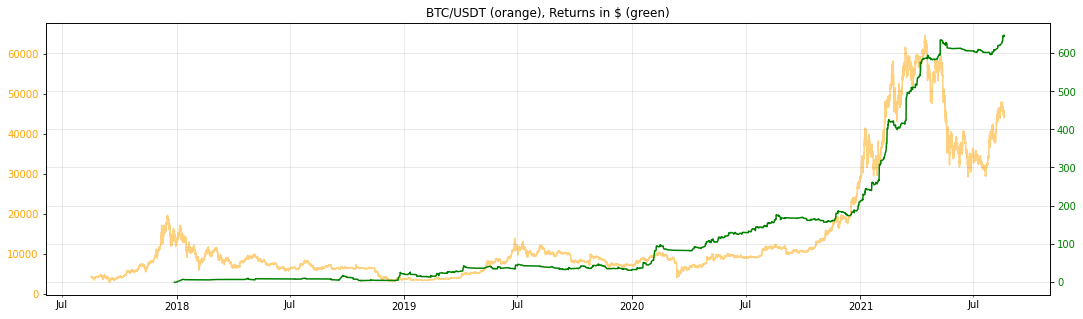

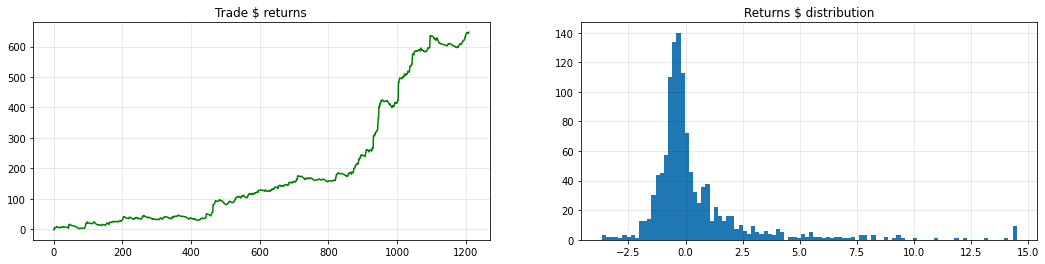

,Portfolio Summary
Min Balance,-2.08
Max Balance,646.99
End Balance,646.99
Trades,1210.00
Avg. Profit %,3.56
Avg. Profit $,0.53
Biggest Profit $,59.10
Biggest Loss $,-3.68


freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'DIY_MACDLongTerm__backtest-2021-08-21_11-17-53'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [12]:
# Backtest settings
strategy_classname = "DIY_MACDLongTerm"  # Strategy Filename and Classname must same! 
timerange          = "20160501-"
pairs              = PAIRS_HIGHCAP_NONSTABLE
# pairs              = [
#     "DOGE/USDT",
#     "BTC/USDT", "ETH/USDT", "ADA/USDT", "XRP/USDT", "BCH/USDT", "EOS/USDT", "NEO/USDT", "NANO/USDT", "XMR/USDT", "ZEC/USDT",
# ]

preset = FilePreset(
    timerange = timerange,
    config_dict = configs.DEFAULT_BUYMARKET,
    path_to_file = PATH_STRATEGIES / f"{strategy_classname}.py",
    path_data = PATH_DATA,
)

# Optional override
preset.overwrite_config(
    strategy_search_path = PATH_STRATEGIES,
    pairs                = pairs,
#     max_open_trades      = 10,     
#     starting_balance     = 1500,   
#     stake_amount         = 15,    
#     timeframe            = "12h", # 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
)

stats, summary = backtest(preset, preset.default_strategy_code, clsname=strategy_classname, dataloader=DATALOADER)
trades = pd.DataFrame(stats["strategy"][strategy_classname]["trades"])
plotting.plot_profits_timerange(
    trades,
    timerange,
    path_mount = PATH_MOUNT,
    name = preset.name
)

# Plot Profits

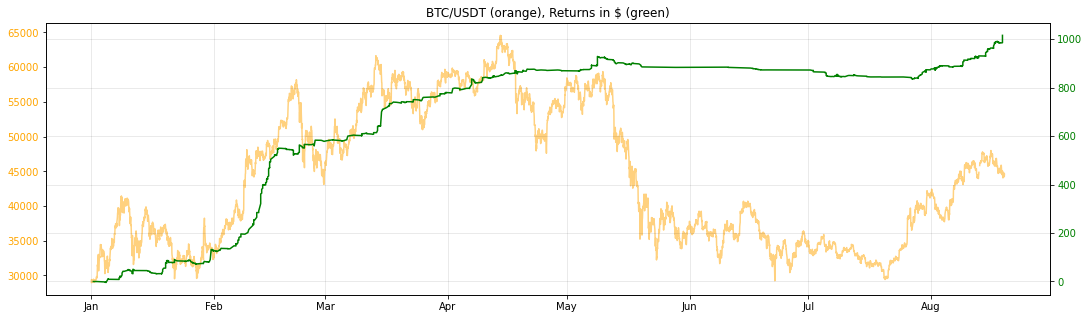

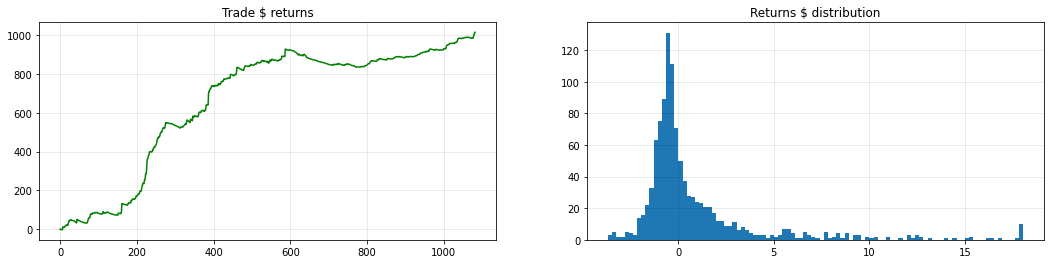

,Portfolio Summary
Min Balance,-3.99
Max Balance,1016.02
End Balance,1016.02
Trades,1083.00
Avg. Profit %,6.25
Avg. Profit $,0.94
Biggest Profit $,59.10
Biggest Loss $,-3.68


In [8]:
plotting.plot_profits(
    trades,
    start = "2021-01-01",
    end = "2021-09-01",
    path_mount = PATH_MOUNT,
    name = preset.name,
)

# Statistics

In [4]:
def process_result_dataframe(result_df):
    result_df = result_df.drop(columns=["profit_mean", "profit_total", "profit_sum"])
    result_df = result_df.sort_values(by=["profit_total_abs"], ascending=False)
    result_df = result_df.round(2)
    return result_df

# Running this cell will print backtest results
results = deepcopy(stats["strategy"][strategy_classname])

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"]).set_index("key")
results_per_pair = process_result_dataframe(results_per_pair)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary']).set_index("sell_reason")
sells = process_result_dataframe(sells)

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades']).set_index("key")
left_open_trades = process_result_dataframe(left_open_trades)

# Summary metrics
metrics = text_table_add_metrics(results)
advanced_metrics = deepcopy(stats["metadata"])
advanced_metrics["profit_mean"] = advanced_metrics["profit_mean"] * 100
advanced_metrics["profit_median"] = advanced_metrics["profit_median"] * 100
advanced_metrics["profit_total"] = advanced_metrics["profit_total"] * 100

for key in list(advanced_metrics):
    value = advanced_metrics[key]
    valid = any(isinstance(value, it) for it in [str, int, float, bool])
    
    if not valid:
        del advanced_metrics[key]
        continue
    
    if isinstance(value, float):
        advanced_metrics[key] =  round(value, 3)
    
    advanced_metrics[key] = [advanced_metrics[key]]
    
advanced_metrics_df = pd.DataFrame(advanced_metrics)
    
print("Results Per Pair")
display(results_per_pair)
print("Sell Reasons")
display(sells)
print("Left Open Trades")
display(left_open_trades)
print("Freqtrade Summary Metrics")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)
print("Advanced Metrics")
print("Preset Name:", advanced_metrics_df["preset_name"][0])
display(advanced_metrics_df.drop(columns=["preset_name"]).T)# Running this cell will print backtest results
results = stats["strategy"]["NotebookStrategy"]

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"])
results_per_pair_df = results_per_pair.set_index("key").drop(columns=["profit_mean", "profit_total"])
results_per_pair_df = results_per_pair_df.sort_values(by=["profit_total_pct"], ascending=False)
results_per_pair_df.round(2)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary'])
sells = sells.drop(columns=["profit_mean", "profit_total"]).set_index("sell_reason")

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades'])
left_open_trades = left_open_trades.drop(columns=["profit_mean", "profit_total"]).set_index("key")

# Summary metrics
metrics = text_table_add_metrics(results)

print("Results Per Pair")
display(results_per_pair_df.round(2))
print("Sell Reasons")
display(sells.round(2))
print("Left Open Trades")
display(left_open_trades.round(2))
print("Summary")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)

Results Per Pair


,trades,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,
TOTAL,2819,3.78,10651.33,1599.30,106.62,"2 days, 16:47:00",1122,0,1697
TFUEL/USDT,48,15.07,723.47,108.63,7.24,"3 days, 0:08:00",22,0,26
CHZ/USDT,46,13.77,633.58,95.13,6.34,"2 days, 23:29:00",21,0,25
FTM/USDT,48,10.43,500.73,75.18,5.01,"2 days, 22:22:00",24,0,24
HOT/USDT,61,7.11,433.64,65.11,4.34,"2 days, 19:17:00",26,0,35
BTT/USDT,51,8.16,416.41,62.52,4.17,"3 days, 2:35:00",22,0,29
OMG/USDT,43,9.16,393.67,59.11,3.94,"3 days, 0:59:00",22,0,21
ETC/USDT,70,5.54,388.04,58.26,3.88,"2 days, 15:36:00",26,0,44
XRP/USDT,63,6.12,385.66,57.91,3.86,"2 days, 20:40:00",27,0,36


Sell Reasons


,trades,wins,draws,losses,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct
sell_reason,,,,,,,,
sell_signal,2813,1117,0,1696,3.71,10448.72,1568.87,171.29
force_sell,6,5,0,1,33.77,202.61,30.42,3.32


Left Open Trades


,trades,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,
TOTAL,6,33.77,202.61,30.42,2.03,"2 days, 16:00:00",5,0,1
SOL/USDT,1,66.39,66.39,9.97,0.66,"5 days, 12:00:00",1,0,0
LUNA/USDT,1,59.19,59.19,8.89,0.59,"3 days, 0:00:00",1,0,0
AVAX/USDT,1,53.25,53.25,8.00,0.53,"2 days, 18:00:00",1,0,0
NEAR/USDT,1,17.89,17.89,2.69,0.18,"1 day, 18:00:00",1,0,0
FTM/USDT,1,8.99,8.99,1.35,0.09,"2 days, 18:00:00",1,0,0
EGLD/USDT,1,-3.10,-3.10,-0.46,-0.03,6:00:00,0,0,1


Freqtrade Summary Metrics
| Metric                 | Value               |
|------------------------+---------------------|
| Backtesting from       | 2017-12-20 00:00:00 |
| Backtesting to         | 2021-08-19 00:00:00 |
| Max open trades        | 61                  |
|                        |                     |
| Total/Daily Avg Trades | 2819 / 2.11         |
| Starting balance       | 1500.000 USDT       |
| Final balance          | 3099.297 USDT       |
| Absolute profit        | 1599.297 USDT       |
| Total profit %         | 106.62%             |
| Avg. stake amount      | 15.000 USDT         |
| Total trade volume     | 42285.000 USDT      |
|                        |                     |
| Best Pair              | TFUEL/USDT 723.47%  |
| Worst Pair             | YFI/USDT -41.3%     |
| Best trade             | CHZ/USDT 393.6%     |
| Worst trade            | EOS/USDT -24.48%    |
| Best day               | 76.865 USDT         |
| Worst day              | -28.928 USDT    

,0
random_name,sadistic-goku-necklace
preset_type,FilePreset
backtest_date,2021-08-21 11:11:13
leverage,1
direction,long
is_hedging,False
fee,0.001
num_pairs,61
data_source,binance
win_rate,0.398


KeyError: 'NotebookStrategy'

freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'DIY_MACDLongTerm__backtest-2021-08-21_11-11-13'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [26]:
qgrid.show_grid(trades)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
DATALOADER.clear()
gc.collect()

0